In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
image_path1 = cv2.imread("MRI_imgs/yes/Y258.JPG", 0)


In [3]:
def _plt(img, cmap, title, fsize, p):
    if p == 0:
        plt.title(title, fontsize=fsize)
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img, cmap=cmap)

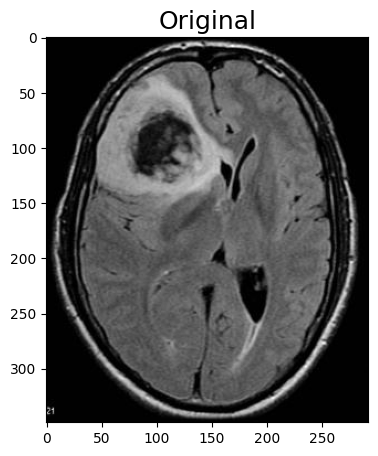

In [4]:
res = 255 - image_path1

fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(121)
_plt(image_path1, 'gray', 'Original', 18, 0)


# Blur

In [5]:
def apply_blur(image):
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    return blurred_image


In [6]:
image_path = "MRI_imgs/yes/Y258.JPG"

Text(0.5, 1.0, 'Blurred Image')

<Figure size 1500x500 with 0 Axes>

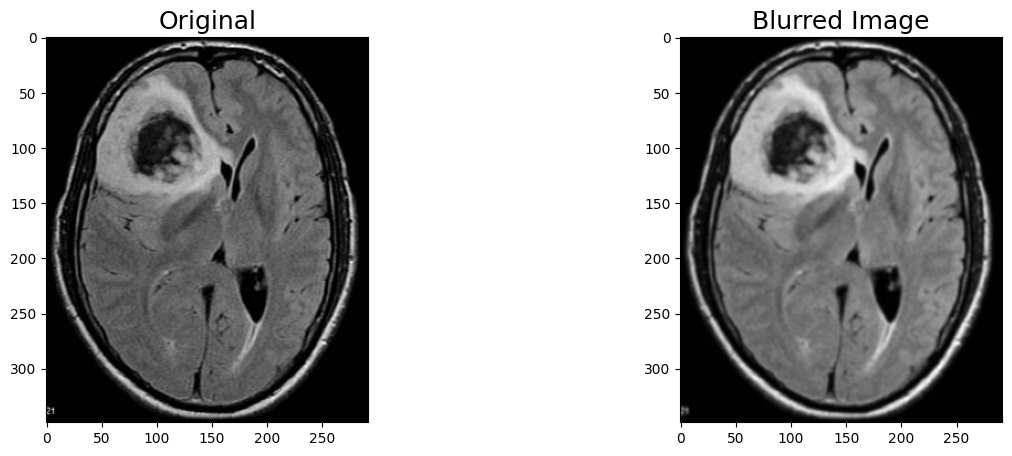

In [7]:
#image_path = "MRI_imgs/yes/Y258.JPG"

# Read the image in grayscale
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Blur
blurred_image = apply_blur(original_image)

# Plot the original and edge-detected images using matplotlib
plt.figure(figsize=(15, 5))

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
_plt(original_image, 'gray', 'Original', 18, 0)

ax = fig.add_subplot(122)
_plt(blurred_image, 'gray', '', '', 1)
ax.set_title('Blurred Image', fontsize=18)

# Gradient Magnitude and Direction

In [8]:
def compute_gradient(image_path):
    # Read the image in grayscale
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply Blur
    blurred_image = apply_blur(original_image)

    # Compute gradients using Sobel operators
    grad_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)

    # Compute gradient magnitude and direction
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    gradient_direction = np.arctan2(grad_y, grad_x)

    return blurred_image, gradient_magnitude, gradient_direction


Gradient Magnitude (Visualized in 'viridis' colormap):

    *High values correspond to areas with rapid changes in intensity (edges).
    *Low values correspond to areas with relatively constant intensity.

Gradient Direction (Visualized in 'hsv' colormap):

    *The color indicates the orientation of the edge. For example, red might represent horizontal edges, while green represents vertical edges.
    *The brightness represents the magnitude of the gradient at that point.

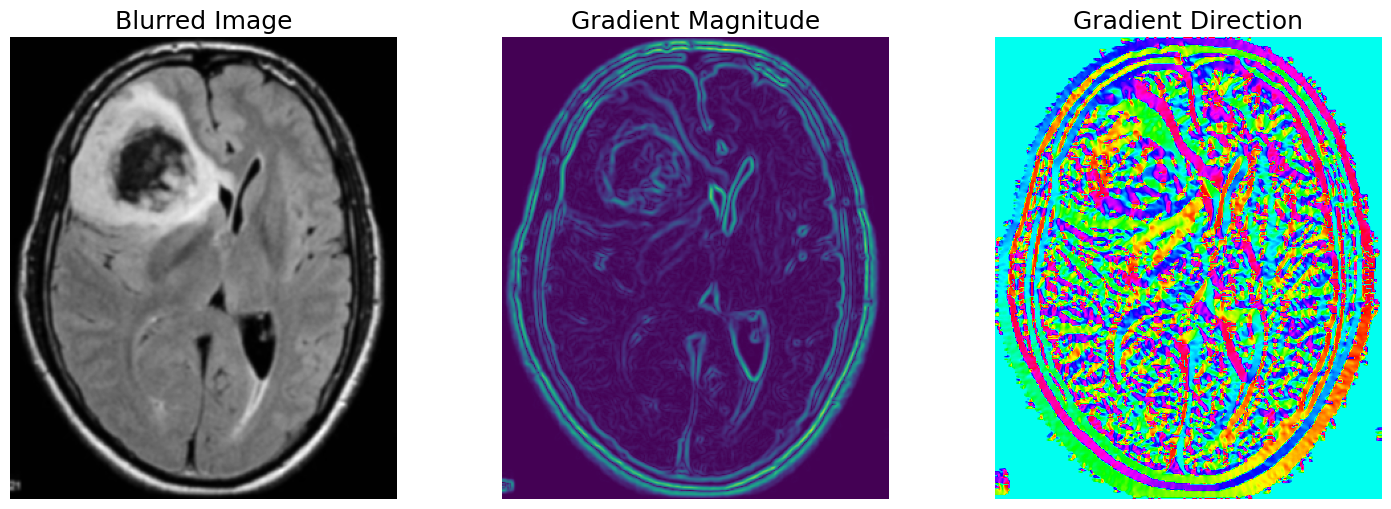

In [9]:
# Example usage

# Call the function to get the results
blurred_image, gradient_magnitude, gradient_direction = compute_gradient(image_path)

# Display the results using matplotlib outside the function
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
_plt(blurred_image, 'gray', 'Blurred Image', 18, 0)
plt.axis('off')

plt.subplot(1, 3, 2)
_plt(gradient_magnitude, 'viridis', 'Gradient Magnitude', 18, 0)
plt.axis('off')

plt.subplot(1, 3, 3)
_plt(gradient_direction, 'hsv', 'Gradient Direction', 18, 0)
plt.axis('off')

plt.show()

# Apply Non-Maximum Suppression

Non-maximum suppression is a technique used in Canny edge detection to eliminate false positives
    
    Removes any unwanted pixels which may not constitute the edge.


In [10]:
def non_maximum_suppression(gradient_magnitude, gradient_direction):
    # Quantize gradient directions into four main directions: 0, 45, 90, and 135 degrees
    quantized_direction = (np.round(gradient_direction * (4.0 / np.pi)) % 4).astype(int)

    rows, cols = gradient_magnitude.shape
    suppressed_magnitude = np.zeros_like(gradient_magnitude)

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            current_magnitude = gradient_magnitude[i, j]

            # Get the neighboring pixels along the gradient direction
            if quantized_direction[i, j] == 0:  # 0 degrees
                neighbors = [gradient_magnitude[i, j - 1], gradient_magnitude[i, j + 1]]
            elif quantized_direction[i, j] == 1:  # 45 degrees
                neighbors = [gradient_magnitude[i - 1, j - 1], gradient_magnitude[i + 1, j + 1]]
            elif quantized_direction[i, j] == 2:  # 90 degrees
                neighbors = [gradient_magnitude[i - 1, j], gradient_magnitude[i + 1, j]]
            else:  # 135 degrees
                neighbors = [gradient_magnitude[i - 1, j + 1], gradient_magnitude[i + 1, j - 1]]

            # Suppress non-maximum pixels
            if current_magnitude >= max(neighbors):
                suppressed_magnitude[i, j] = current_magnitude

    return suppressed_magnitude

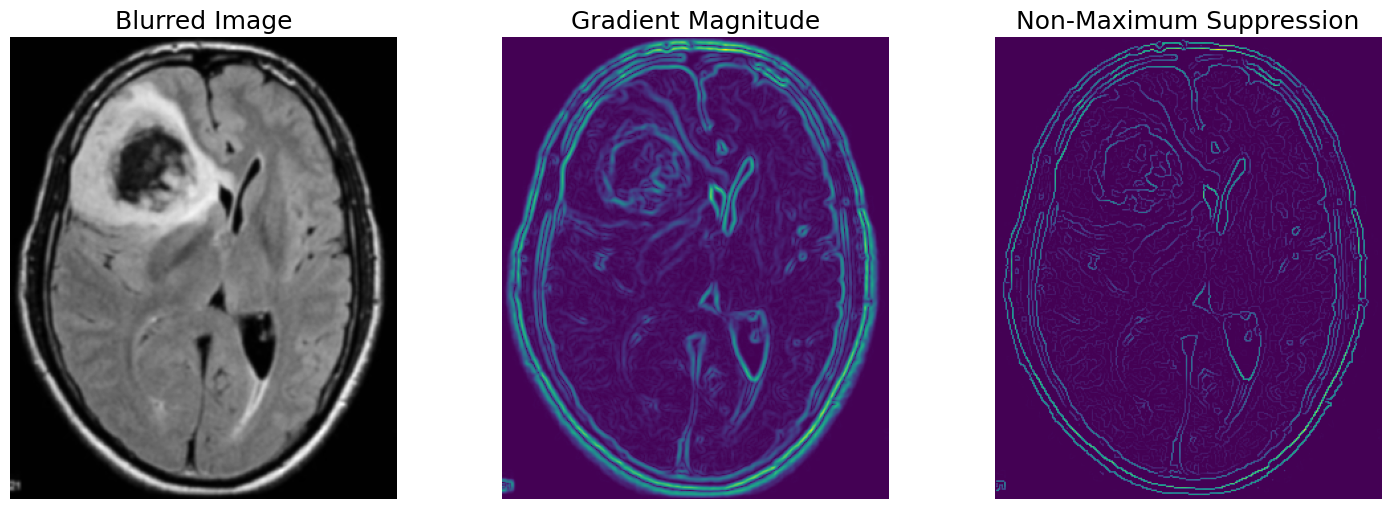

In [11]:
# Example usage

# Call the function to get the results
blurred_image, gradient_magnitude, gradient_direction = compute_gradient(image_path)

# Apply non-maximum suppression
suppressed_magnitude = non_maximum_suppression(gradient_magnitude, gradient_direction)

# Display the results using matplotlib outside the function
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
_plt(blurred_image, 'gray', 'Blurred Image', 18, 0)
plt.axis('off')

plt.subplot(1, 3, 2)
_plt(gradient_magnitude, 'viridis', 'Gradient Magnitude', 18, 0)
plt.axis('off')

plt.subplot(1, 3, 3)
_plt(suppressed_magnitude, 'viridis', 'Non-Maximum Suppression', 18, 0)
plt.axis('off')

plt.show()

# Hysteresis Threshold

Hysteresis thresholding is often used in edge detection, where the goal is to identify continuous edges in an image. By using hysteresis, the algorithm can better handle noisy or textured regions, ensuring that edges are detected more robustly.

In [12]:
def hysteresis_threshold(image, low_threshold, high_threshold):
    # Apply dual thresholding
    high_threshold_mask = (image >= high_threshold)
    low_threshold_mask = (image >= low_threshold) & (image < high_threshold)

    # Initialize the result image with weak edges
    result_image = np.zeros_like(image)

    # Labeling strong and weak edges
    result_image[high_threshold_mask] = 1
    result_image[low_threshold_mask] = 0.5  # Using 0.5 for weak edges

    # Identify weak edges connected to strong edges
    _, labels, stats, _ = cv2.connectedComponentsWithStats(result_image.astype(np.uint8), connectivity=8)

    # Assign strong label (1) to weak edges connected to strong edges
    for i in range(1, labels.max() + 1):
        if stats[i, cv2.CC_STAT_AREA] > 0:
            result_image[labels == i] = 1

    # Convert the result to a binary image
    result_image = np.uint8(result_image)

    return result_image


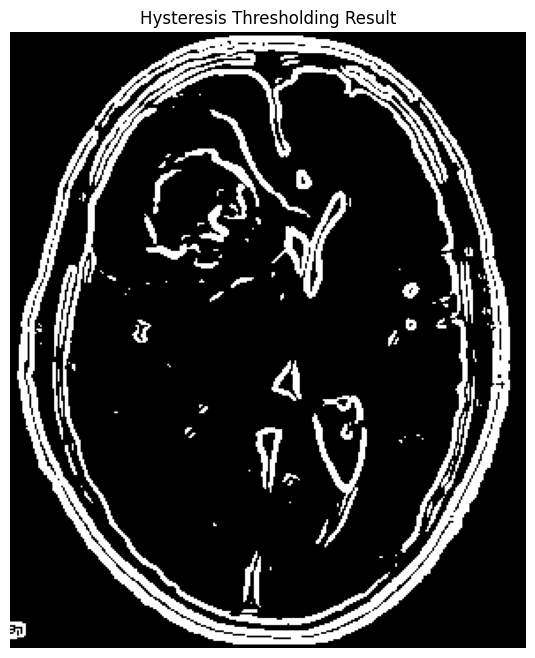

In [13]:
# Example usage
''' Assuming you have the gradient magnitude variable from the previous response'''

# Read the image in grayscale

# Call the compute_gradient function to get the results
blurred_image, gradient_magnitude, gradient_direction = compute_gradient(image_path)

# Set your desired low and high thresholds
low_threshold = 30
high_threshold = 100

# Apply hysteresis thresholding
result_image2 = hysteresis_threshold(gradient_magnitude, low_threshold, high_threshold)

# Display the result
plt.figure(figsize=(8, 8))
plt.imshow(result_image2, cmap='gray')
plt.title('Hysteresis Thresholding Result')
plt.axis('off')
plt.show()

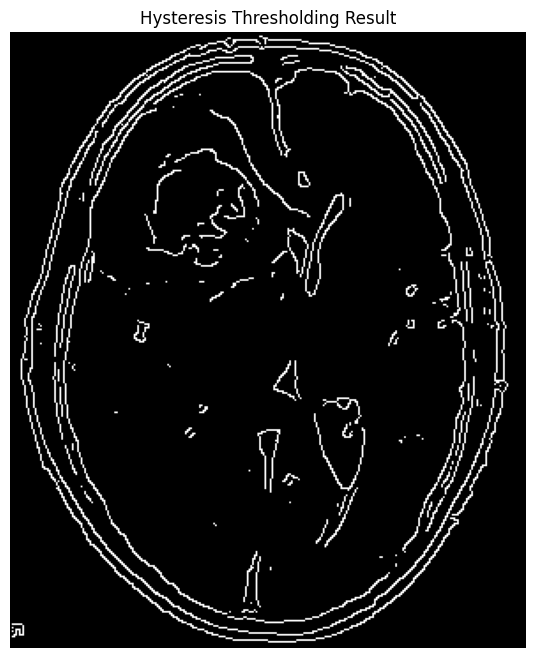

In [14]:
# Example usage
'''Assuming you have the suppressed_magnitude '''

# Read the image in grayscale

# Call the compute_gradient function to get the results
blurred_image, gradient_magnitude, gradient_direction = compute_gradient(image_path)


# Apply non-maximum suppression
suppressed_magnitude = non_maximum_suppression(gradient_magnitude, gradient_direction)


# Set your desired low and high thresholds
low_threshold = 30
high_threshold = 100

# Apply hysteresis thresholding
result_image = hysteresis_threshold(suppressed_magnitude, low_threshold, high_threshold)

# Display the result
plt.figure(figsize=(8, 8))
plt.imshow(result_image, cmap='gray')
plt.title('Hysteresis Thresholding Result')
plt.axis('off')
plt.show()

<Figure size 1500x500 with 0 Axes>

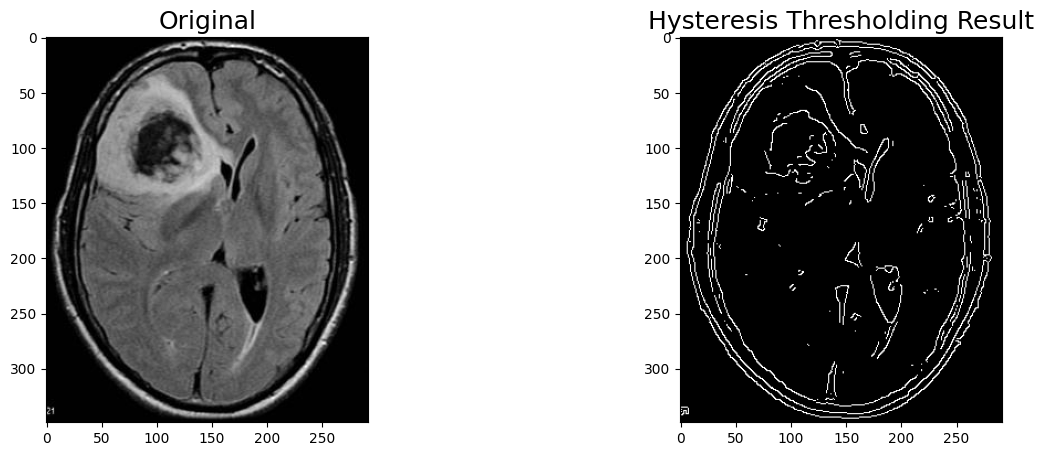

In [51]:

# Read the image in grayscale

# Call the compute_gradient function to get the results
blurred_image, gradient_magnitude, gradient_direction = compute_gradient(image_path)

# Apply non-maximum suppression
suppressed_magnitude = non_maximum_suppression(gradient_magnitude, gradient_direction)


# Set your desired low and high thresholds
low_threshold = 30
high_threshold = 100

# Apply hysteresis thresholding
result_image = hysteresis_threshold(suppressed_magnitude, low_threshold, high_threshold)

# Plot the original and edge-detected images using matplotlib
plt.figure(figsize=(15, 5))

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
_plt(original_image, 'gray', 'Original', 18, 0)

ax = fig.add_subplot(122)
_plt(result_image, 'gray', '', '', 1)
ax.set_title('Hysteresis Thresholding Result', fontsize=18)

# Save the result_image
plt.imsave('hysteresis_image.jpg', result_image, cmap='gray')

This is Edge detection using predefined Canny() and GaussianBlur() functions

True

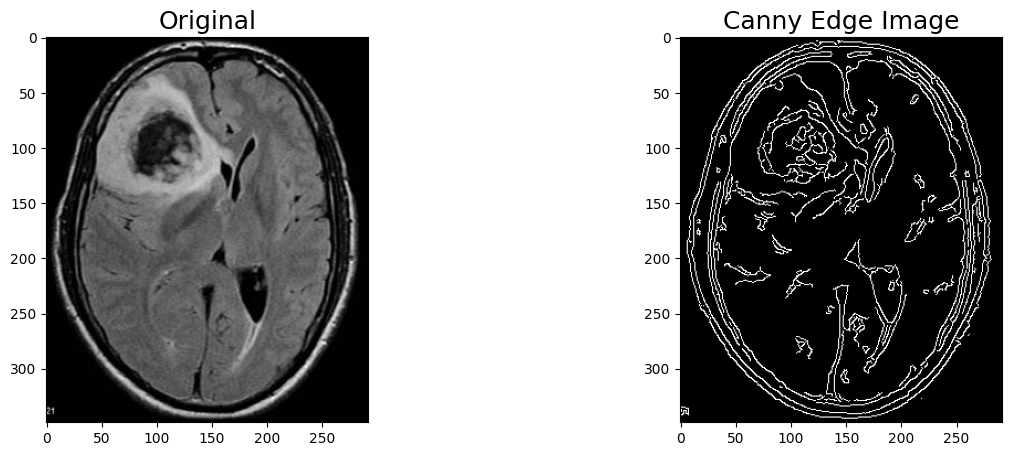

In [17]:
minVal = 30
maxVal = 100

img = cv2.imread('MRI_imgs/yes/Y258.JPG',0)
blurred_image = cv2.GaussianBlur(img , (5, 5), 0)

edges = cv2.Canny(blurred_image,minVal,maxVal)


fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
_plt(img,'gray','Original',18,0)

ax = fig.add_subplot(122)

_plt(edges, 'gray','','', 1)
ax.set_title('Canny Edge Image', fontsize=18)

# Save the Canny edge image
cv2.imwrite('canny_edge_image.jpg', edges)

Canny Edge and Hysteresis Thresholding Comparison

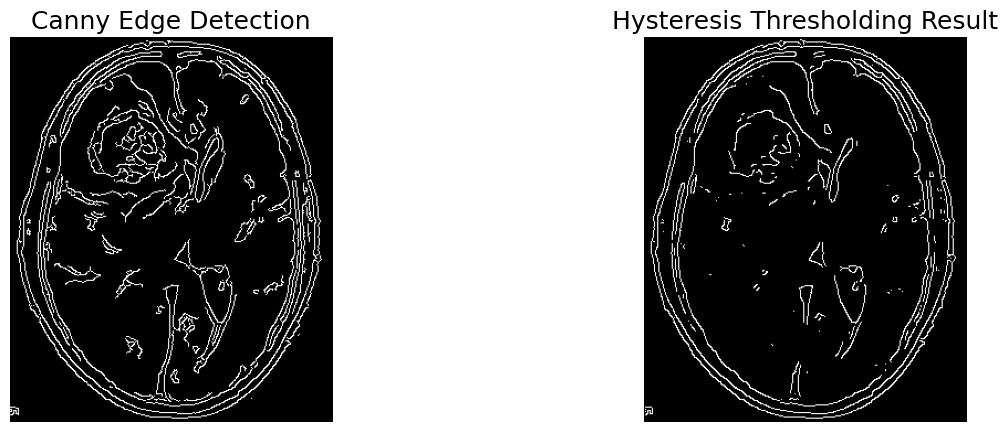

In [46]:
# Normal Canny Edge Detection
minVal = 30
maxVal = 100

img = cv2.imread('MRI_imgs/yes/Y258.JPG', 0)
blurred_image_canny = cv2.GaussianBlur(img, (5, 5), 0)
edges_canny = cv2.Canny(blurred_image_canny, minVal, maxVal)

# Hysteresis Edge Detection
blurred_image_hysteresis, gradient_magnitude, gradient_direction = compute_gradient(image_path)

# Apply non-maximum suppression
suppressed_magnitude = non_maximum_suppression(gradient_magnitude, gradient_direction)


low_threshold_hysteresis = 30
high_threshold_hysteresis = 100
result_image_hysteresis = hysteresis_threshold(suppressed_magnitude, low_threshold_hysteresis, high_threshold_hysteresis)

# Plot the original and edge-detected images using matplotlib
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
_plt(edges_canny, 'gray', 'Canny Edge Detection', 18, 0)
plt.axis('off')

plt.subplot(1, 2, 2)
_plt(result_image_hysteresis, 'gray', 'Hysteresis Thresholding Result', 18, 0)
plt.axis('off')

plt.show()

In [63]:
'''
Designing a good edge detection should be as close as possible to the actual edges in the original image. 
Therefore, to verify the closeness/similarity, please use a preliminary evaluation for the enhanced gray 
image from the original using distance measurement such as the Structural Similarity Index (SSI).

In this part, the Structural Similarity Index (SSI) measures the enhanced images (Enhancement Methods from the previous 
activity) as point 2 from the original images as point 1. & Then convert the results to percentages.
'''

# Load the original and enhanced images
original_image_path = "MRI_imgs/yes/Y258.JPG"
canny_image_path = "canny_edge_image.jpg"
hysteresis_image_path = "hysteresis_image.jpg"

original_image = io.imread(original_image_path, as_gray=True)
canny_image = io.imread(canny_image_path, as_gray=True)
hysteresis_image = io.imread(hysteresis_image_path, as_gray=True)

# Verify the shapes of the images
assert original_image.shape == canny_image.shape, "Canny - Images must have the same dimensions"
assert original_image.shape == hysteresis_image.shape, "Hysteresis - Images must have the same dimensions"

import cv2
from skimage.metrics import structural_similarity as ssim
import numpy as np

def calculate_ssim(original_img, enhanced_img):
    # Convert images to grayscale if they are not already
    if original_img.shape[-1] == 3:
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    if enhanced_img.shape[-1] == 3:
        enhanced_img = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2GRAY)

    # Normalize pixel values to the range [0, 1]
    original_img = original_img / 255.0
    enhanced_img = enhanced_img / 255.0

    # Calculate SSIM
    ssim_value, _ = ssim(original_img, enhanced_img, data_range=original_img.max() - enhanced_img.min(), full=True)

    # Convert SSIM to percentage (multiply by 100)
    ssim_percentage = ssim_value * 100

    return ssim_percentage

# Canny Edge
print("Canny Edge:")
similarity_percentage = calculate_ssim(original_image, canny_image)
print(f"Similarity Percentage: {similarity_percentage}%")

# Hysteresis
print("Hysteresis:")
similarity_percentage = calculate_ssim(original_image, hysteresis_image)
print(f"Similarity Percentage: {similarity_percentage}%")

Canny Edge:
Similarity Percentage: 14.694416871647867%
Hysteresis:
Similarity Percentage: 18.791927652115717%


*****

# Morphology 
Erosion and Dilation
- Dilation adds pixels to the boundaries of objects in an image
- Erosion removes pixels on object boundaries. 

In [57]:
# Function for erosion and dilation
def apply_erosion_dilation(image, kernel_size, iterations):
    # Taking a matrix of size kernel_size as the kernel
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Erosion and dilation
    img_erosion = cv2.erode(image, kernel, iterations=iterations)
    img_dilation = cv2.dilate(image, kernel, iterations=iterations)

    return img_erosion, img_dilation

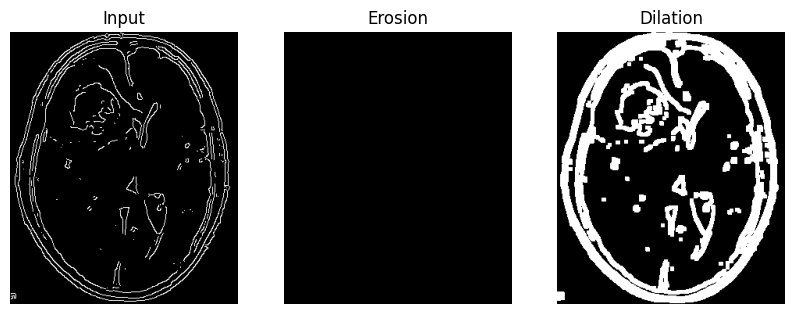

In [56]:
# Set parameters for erosion and dilation
kernel_size = 5
iterations = 1

# Apply erosion and dilation
img_erosion, img_dilation = apply_erosion_dilation(result_image_hysteresis, kernel_size, iterations)

# Display the images using matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(result_image_hysteresis, cmap='gray')
plt.title('Input')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_erosion, cmap='gray')
plt.title('Erosion')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_dilation, cmap='gray')
plt.title('Dilation')
plt.axis('off')

plt.show()


Used result_image2 which is the hysteresis_threshold that uses "gradient_magnitude" variable instead of "suppressed_magnitude" magnitude

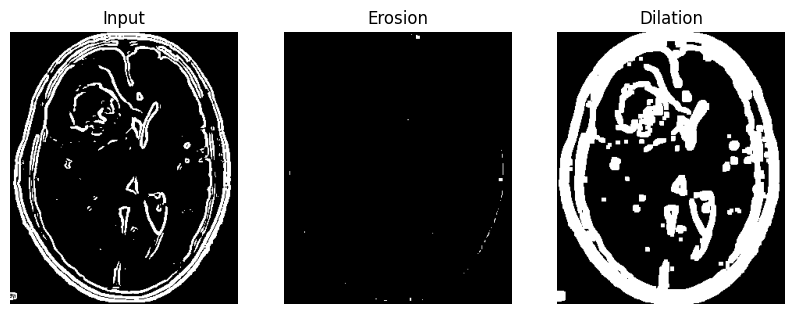

In [49]:
# Set parameters for erosion and dilation
kernel_size = 5
iterations = 1

# Apply erosion and dilation
img_erosion, img_dilation = apply_erosion_dilation(result_image2, kernel_size, iterations)

# Display the images using matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(result_image2, cmap='gray')
plt.title('Input')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_erosion, cmap='gray')
plt.title('Erosion')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_dilation, cmap='gray')
plt.title('Dilation')
plt.axis('off')

plt.show()


# Contour Detection


Number of Contours: 0
Number of Contours: 110


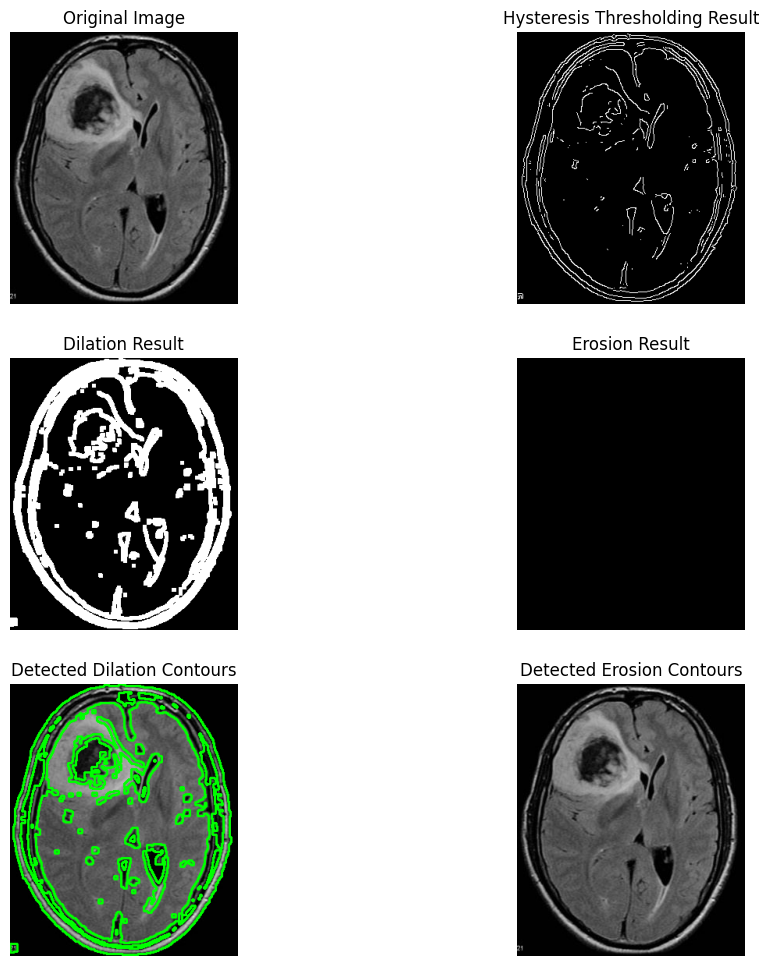

In [61]:
# Load an image
file = 'MRI_imgs/yes/Y258.JPG'
img = cv2.imread(file)

# OpenCV to Matplotlib color adjustment
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Set your desired low and high thresholds for hysteresis thresholding
low_threshold = 30
high_threshold = 100

# Find contours in the binary image
'''using img_erosion '''
erosion_contours, _ = cv2.findContours(img_erosion, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

'''using img_dilation'''
dilation_contours, _ = cv2.findContours(img_dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


# Create a copy of the original image for drawing contours
detected_erosion_contours = img_rgb.copy()

detected_dilation_contours = img_rgb.copy()

# Draw the contours on the copy of the original image
cv2.drawContours(detected_erosion_contours, erosion_contours, -1, (0, 255, 0), 2)
print("Number of Contours:", len(erosion_contours))

cv2.drawContours(detected_dilation_contours, dilation_contours, -1, (0, 255, 0), 2)
print("Number of Contours:", len(dilation_contours))

# Display the images using matplotlib
plt.figure(figsize=(12, 12))

plt.subplot(3, 2, 1)
plt.imshow(img_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(3, 2, 2)
plt.imshow(result_image_hysteresis, cmap='gray')
plt.title('Hysteresis Thresholding Result')
plt.axis('off')

plt.subplot(3, 2, 3)
plt.imshow(img_dilation, cmap='gray')
plt.title('Dilation Result')
plt.axis('off')

plt.subplot(3, 2, 4)
plt.imshow(img_erosion, cmap='gray')
plt.title('Erosion Result')
plt.axis('off')

plt.subplot(3, 2, 5)
plt.imshow(detected_dilation_contours, cmap='gray')  # Use a colormap that shows green
plt.title('Detected Dilation Contours')
plt.axis('off')

plt.subplot(3, 2, 6)
plt.imshow(detected_erosion_contours, cmap='gray')  # Use a colormap that shows green
plt.title('Detected Erosion Contours')
plt.axis('off')


plt.show()